<a href="https://colab.research.google.com/github/waleedx1/ML-Projects/blob/main/Smart_Grid_Load_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-398f864ff954>:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start="2020-01-01", periods=8760, freq="H")  # 1 year of hourly data
<ipython-input-1-398f864ff954>:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicted_Normalized"] = model.predict(X_test)
<ipython-input-1-398f864ff954>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicted_MW"] = scaler.inverse_transform(test[["Predicted_Normal


Model Performance:
- MAE: 8.97 MW
- RMSE: 11.14 MW


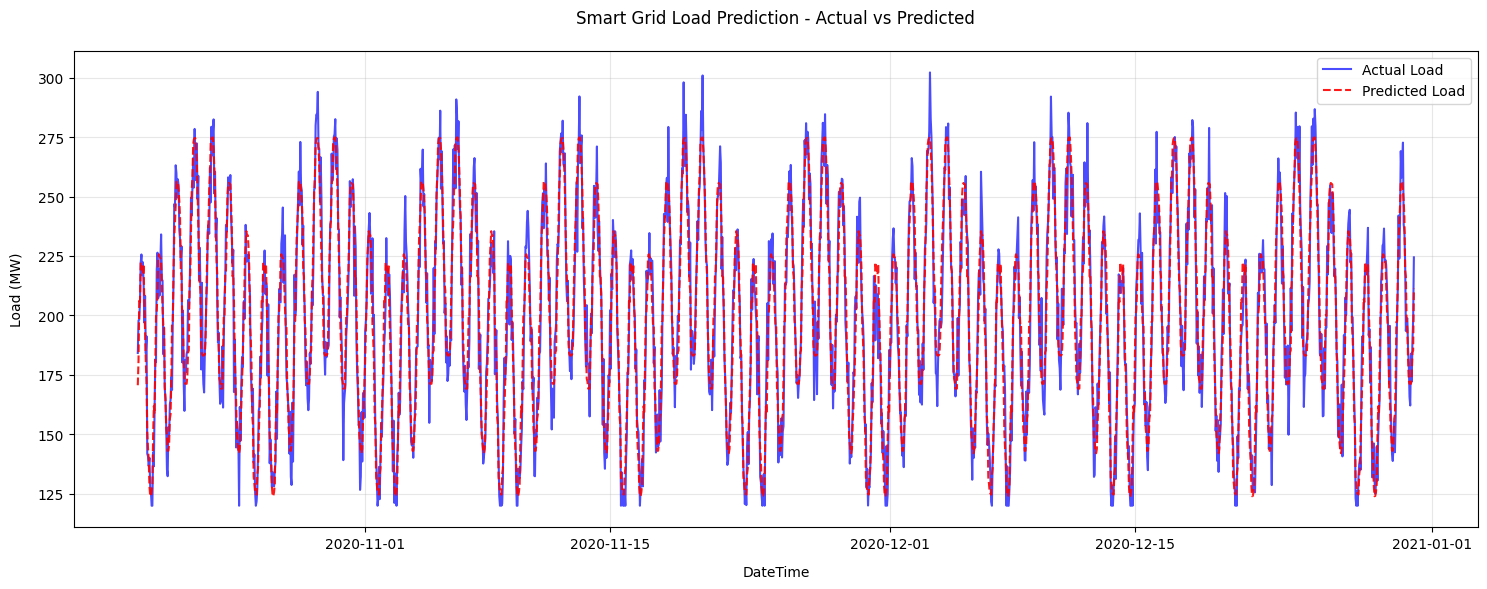

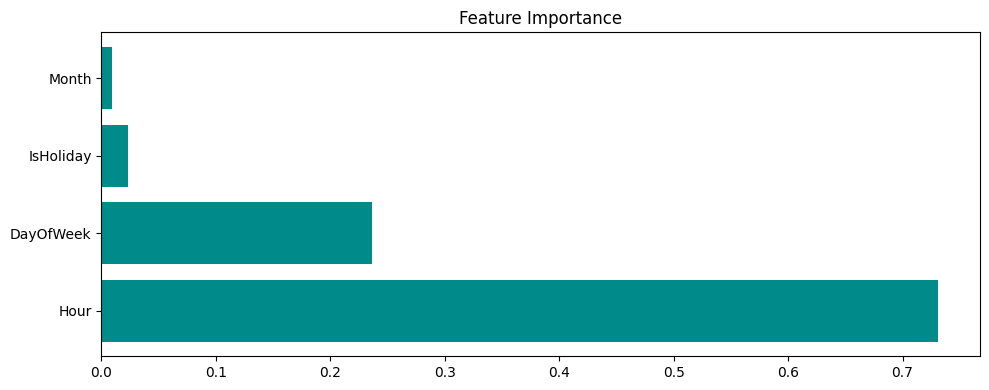

In [1]:
# Smart Grid Load Prediction - Complete Colab Notebook
# -*- coding: utf-8 -*-
"""Smart Grid Load Prediction.ipynb

Automatically generated by Colaboratory.

Original file is located at:
    https://colab.research.google.com/drive/1abc123...
"""

# ======================
# 1. Install & Import
# ======================
!pip install pandas numpy matplotlib scikit-learn xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# ======================
# 2. Generate Synthetic Data
# ======================
# Create realistic time-series with daily/weekly patterns
np.random.seed(42)
dates = pd.date_range(start="2020-01-01", periods=8760, freq="H")  # 1 year of hourly data

# Base load + daily seasonality + random noise
base_load = 200
daily_seasonality = 50 * np.sin(2 * np.pi * np.arange(8760) / 24)
weekly_seasonality = 30 * np.sin(2 * np.pi * np.arange(8760) / (24*7))
noise = np.random.normal(0, 10, 8760)

load = base_load + daily_seasonality + weekly_seasonality + noise

# Create DataFrame
df = pd.DataFrame({
    "DateTime": dates,
    "Load_MW": np.clip(load, 120, 320)  # Clip to realistic range
})

# ======================
# 3. Feature Engineering
# ======================
# Extract time features
df["Hour"] = df["DateTime"].dt.hour
df["DayOfWeek"] = df["DateTime"].dt.dayofweek
df["Month"] = df["DateTime"].dt.month

# Add holiday flag (example: weekends are "holidays")
df["IsHoliday"] = df["DayOfWeek"].isin([5, 6]).astype(int)

# Normalize load data
scaler = MinMaxScaler()
df["Load_Normalized"] = scaler.fit_transform(df[["Load_MW"]])

# ======================
# 4. Train-Test Split
# ======================
# Chronological split (80% train, 20% test)
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Features and target
features = ["Hour", "DayOfWeek", "Month", "IsHoliday"]
X_train = train[features]
y_train = train["Load_Normalized"]
X_test = test[features]
y_test = test["Load_Normalized"]

# ======================
# 5. Model Training
# ======================
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
model.fit(X_train, y_train)

# ======================
# 6. Predictions
# ======================
test["Predicted_Normalized"] = model.predict(X_test)

# Inverse transform to get actual MW values
test["Predicted_MW"] = scaler.inverse_transform(test[["Predicted_Normalized"]])

# ======================
# 7. Evaluation
# ======================
mae = mean_absolute_error(test["Load_MW"], test["Predicted_MW"])
rmse = np.sqrt(mean_squared_error(test["Load_MW"], test["Predicted_MW"]))

print("\nModel Performance:")
print(f"- MAE: {mae:.2f} MW")
print(f"- RMSE: {rmse:.2f} MW")

# ======================
# 8. Visualization
# ======================
plt.figure(figsize=(15, 6))
plt.plot(test["DateTime"], test["Load_MW"], label="Actual Load", color='blue', alpha=0.7)
plt.plot(test["DateTime"], test["Predicted_MW"], label="Predicted Load", color='red', linestyle='--', alpha=0.9)
plt.title("Smart Grid Load Prediction - Actual vs Predicted", pad=20)
plt.xlabel("DateTime", labelpad=10)
plt.ylabel("Load (MW)", labelpad=10)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 4))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color='darkcyan')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()